<a href="https://colab.research.google.com/github/hayari/MaskedFace/blob/master/MaskedFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from numpy import random

from sklearn.utils import shuffle
import cv2
from sklearn.metrics import confusion_matrix

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

from keras.models import load_model


np.random.seed(100)
%matplotlib inline

# Load the DataSet

In [31]:
image_width=128
image_height=128

In [2]:
dataset=np.load('/content/drive/My Drive/DataSets/dataMasked.npz')

In [3]:
data=dataset['arr_0']
labels=dataset['arr_1']

In [4]:
print(data.shape)
print(labels.shape)

(119079, 128, 128, 3)
(119079,)


In [5]:
type(data)

numpy.ndarray

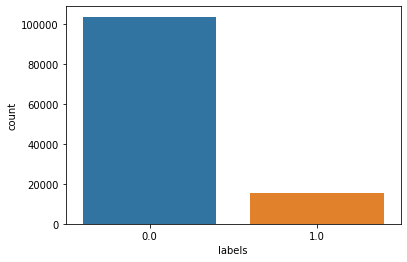

In [6]:
sns.countplot(x='labels',data=pd.DataFrame(labels,columns=['labels']))

In [7]:
 X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=1)
 del(data)
 del(labels)

In [8]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 95263
number of test examples = 23816
X_train shape: (95263, 128, 128, 3)
Y_train shape: (95263,)
X_test shape: (23816, 128, 128, 3)
Y_test shape: (23816,)


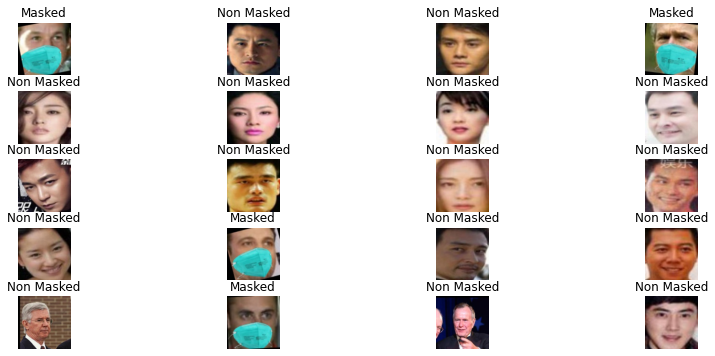

In [9]:
def show_images(X,Y,r,c):
  fig, axs = plt.subplots(r,c, figsize=(15, 6))
  fig.subplots_adjust(hspace = .3, wspace=.001)
  axs = axs.ravel()
  for i in range(r*c): # if rows = 2 and columns = 5 i should take 10 values
      index = random.randint(0, len(X))
      image = X[index]
      axs[i].axis('off')
      axs[i].imshow(image)
      axs[i].set_title(['Masked' if Y[index]==1 else 'Non Masked'][0])
  plt.show()    

# show image of 10 random data points
rows = 5
columns = 4
show_images (X_train,Y_train,rows,columns)

In [10]:
# normalization the images 
def normalize(x):
    return (x.astype(float) - 128) / 128
#new_X_test = np.apply_along_axis(normalize,3,X_test)
#new_X_train = np.apply_along_axis(normalize,3,X_train)

In [11]:
# Shuffle the data

#X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

#X_test, Y_test = shuffle(X_test, Y_test, random_state=0)


# Data Augmentation

In [12]:
# Data augmentation
def random_translate(img):
    rows,cols,_ = img.shape
    
    # allow translation up to px pixels in x and y directions
    px = 2
    dx,dy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst


In [13]:

def random_scaling(img):   
    rows,cols,_ = img.shape

    # transform limits
    px = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

In [14]:
def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

In [15]:
def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst

# Building the Model

In [16]:
model = Sequential([
                    Conv2D(filters=32,padding='same',kernel_size=(3,3), activation='relu',input_shape=(image_width, image_height, 3)),
                    BatchNormalization(),
                    MaxPooling2D(),
                    Flatten(),
                    Dense(1, activation='sigmoid')
                    ])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 131073    
Total params: 132,097
Trainable params: 132,033
Non-trainable params: 64
_________________________________________________________________


In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [20]:
from keras.callbacks import EarlyStopping
stopcallback = EarlyStopping(monitor='loss', patience=10,min_delta=0.001)
history_model = model.fit(X_train,Y_train,epochs=100, batch_size=32, validation_split=0.1,callbacks=[stopcallback],shuffle=True)

Epoch 1/100
2680/2680 [==============================] - 24s 9ms/step - loss: 0.2524 - accuracy: 0.9896 - val_loss: 0.9302 - val_accuracy: 0.9529
Epoch 2/100
2680/2680 [==============================] - 24s 9ms/step - loss: 0.1152 - accuracy: 0.9938 - val_loss: 0.1137 - val_accuracy: 0.9945
Epoch 3/100
2680/2680 [==============================] - 25s 9ms/step - loss: 0.0750 - accuracy: 0.9949 - val_loss: 74.9390 - val_accuracy: 0.1907
Epoch 4/100
2680/2680 [==============================] - 25s 9ms/step - loss: 0.0702 - accuracy: 0.9948 - val_loss: 0.1087 - val_accuracy: 0.9941
Epoch 5/100
2680/2680 [==============================] - 24s 9ms/step - loss: 0.0444 - accuracy: 0.9958 - val_loss: 0.1528 - val_accuracy: 0.9917
Epoch 6/100
2680/2680 [==============================] - 24s 9ms/step - loss: 0.0370 - accuracy: 0.9960 - val_loss: 0.0814 - val_accuracy: 0.9937
Epoch 7/100
2680/2680 [==============================] - 24s 9ms/step - loss: 0.0233 - accuracy: 0.9967 - val_loss: 0.0475 

# Evaluate / Test

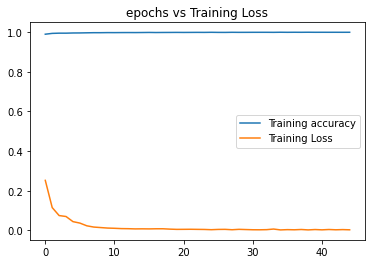

In [21]:
train_accuracy = history_model.history['accuracy']
train_loss = history_model.history['loss']

count = range(len(train_accuracy))
plt.plot(count, train_accuracy, label='Training accuracy')
plt.plot(count, train_loss, label='Training Loss')
plt.title('epochs vs Training Loss')
plt.legend()

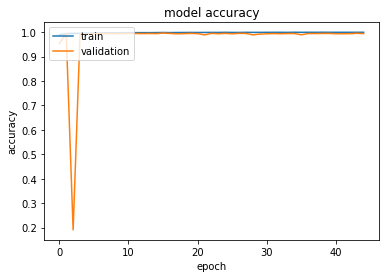

In [22]:
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [24]:
result= model.evaluate(
  X_test,
  Y_test.reshape(-1))
 
print(result)

745/745 [==============================] - 4s 5ms/step - loss: 0.1589 - accuracy: 0.9938
[0.15891245007514954, 0.9938277006149292]


In [25]:
confusion_matrix(Y_test.reshape(-1),model.predict_classes(X_test))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[20678,    49],
       [   98,  2991]])

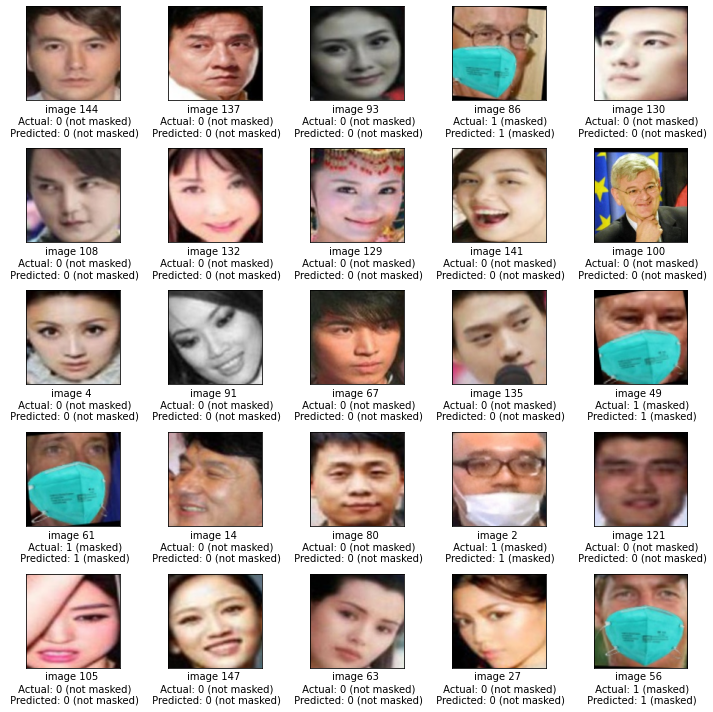

In [27]:
text_labels={
    0: "not masked",
    1: "masked"
}

def plot_prediction_sample(model):
  test_predictions=model.predict_classes(X_test)
  plt.figure(figsize=(10,10))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid('off')
      
      img_index = np.random.randint(0, 150)
      
      plt.imshow(X_test[img_index], cmap=plt.cm.gray)
      
      actual_label = int(Y_test[img_index])
      predicted_label = int(test_predictions[img_index])
      
      plt.xlabel("image {} \n Actual: {} ({})\n Predicted: {} ({})".format(
          img_index,actual_label, text_labels[actual_label], predicted_label, text_labels[predicted_label]
      ))
      
  plt.tight_layout()
  plt.show()
plot_prediction_sample(model)

In [30]:
model.save('/content/drive/My Drive/DataSets/my_model_128.h5')